In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

# PyMC

[PyMC](https://docs.pymc.io/) is an MCMC package for python.  It has many samplers built in that are far more efficient than anything we could write in this course, and has knowledge of many distributions and parameter types to allow us to code posterior distribution functions at a very high level.

This isn't installed in the docker image we've been using.  We could install it with `!pip install pymc3`, however, there are a few tricks to make it run faster.  We could set up our environment each time we import it, or create a new docker image that will do this for us.

In [2]:
import pymc3 as pm

## Linear Regression

Let's revisit the linear regression example from week 1.

In [3]:
!wget -q --no-check-certificate https://astrostatistics.psu.edu/datasets/censor.dat

In [4]:
import pandas as pd

df = pd.read_csv('censor.dat', delim_whitespace=True)
df

,Star,Type,Teff,Ind_Be,logN_Be,sig_Be,Ind_Li,logN_Li
0,BD-103166,1,5320,1,0.50,NaN,1,NaN
1,HD_6434,1,5835,1,1.08,0.10,0,0.80
2,HD_9826,1,6212,1,1.05,0.13,1,2.55
3,HD_10647,1,6143,1,1.19,0.10,1,2.80
4,HD_10697,1,5641,1,1.31,0.13,1,1.96
...,...,...,...,...,...,...,...,...
63,HD_85117,2,6167,1,1.11,0.11,1,2.64
64,HD_189567,2,5765,1,1.06,0.10,0,0.82
65,HD_192310,2,5069,0,0.60,NaN,0,0.20
66,HD_211415,2,5890,1,1.12,0.10,1,1.92


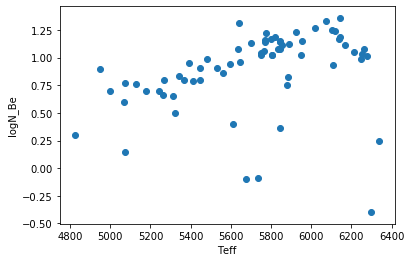

In [5]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name);

Let's assume that whatever scatter is happening on top of the linear process is normally distributed.

$$
\log N_\mathrm{Be} \sim \mathcal{N}(\mu, \sigma^2)
\\
\mu = \alpha + \beta T_\mathrm{eff}
$$

In [6]:
# Initialize random number generator
np.random.seed(123)

# predictor variable
X = df.Teff

# outcome variable
Y = df.logN_Be

We're now going to estimate the posterior distribution function describing our inference of the slope $\beta$ and y-intercept $\alpha$.

To do that we'll first need to establish some priors.  Let's start with:
$$
\alpha \sim \mathcal{N}(0, 100)
\\
\beta \sim \mathcal{N}(0, 100)
\\
\sigma \sim |\mathcal{N}(0, 1)|
$$

Now we build our statistical model for the data.  Model parameters (i.e., the things we're trying to infer) need prior distributions, and observed variables need data (i.e. a likelihood distribution).

In [7]:
linear_model = pm.Model()

with linear_model:
    # Priors for unknown model parameters
    α = pm.Normal('Intercept', mu=0, sd=10)
    β = pm.Normal('Slope', mu=0, sd=10)
    σ = pm.HalfNormal('noise_sd', sd=10)

    # Expected value of outcome
    μ = α + β * X

    # Likelihood of observations
    Y_obs = pm.Normal('Y_obs', mu=μ, sd=σ, observed=Y)

If we just want a quick point estimate (i.e., single set of parameter values) we can find the _maximum a posteriori_ (MAP) with the `find_MAP()` function.

In [8]:
map_estimate = pm.find_MAP(model=linear_model)

map_estimate

logp = -31.671, ||grad|| = 251.3: 100%|██████████| 34/34 [00:00<00:00, 396.44it/s]       


{'Intercept': array(-0.00017527),
 'Slope': array(0.0001567),
 'noise_sd_log__': array(-1.08514014),
 'noise_sd': array(0.33785443)}

Comparing the MAP model to the data...

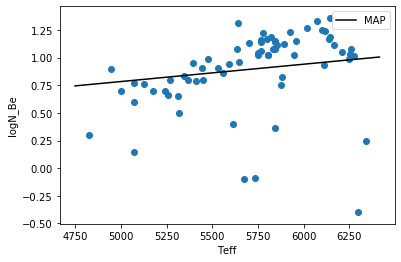

In [9]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)

xlow, xhigh = plt.xlim()
xs = np.linspace(xlow, xhigh)
plt.plot(xs, map_estimate['Intercept'] + xs * map_estimate['Slope'], color='k', label='MAP')
plt.legend();

Now let's sample the posterior distribution.  First we'll use a Metropolis algorithm like we wrote ourselves.

In [13]:
with linear_model:
    # instantiate sampler
    step = pm.Metropolis()

    # Take 10000 steps
    trace = pm.sample(10000, step=step, chains=4, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [noise_sd]
>Metropolis: [Slope]
>Metropolis: [Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:35<00:00, 1195.18draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


The walltime taken per step is small, but the warnings about small numbers of effective samples suggest that we need to evolve the chains for (a lot) longer to collect a reasonable number of independent samples.

Let's take a look at the 1-D distributions and chains to assess sampling quality.

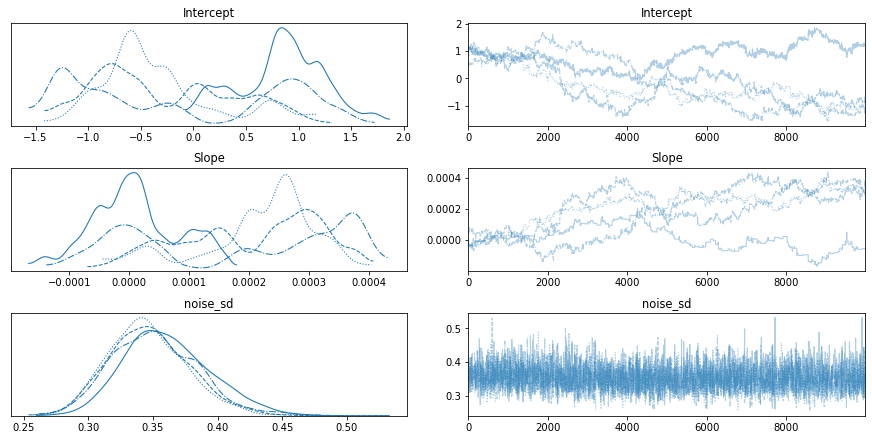

In [14]:
pm.traceplot(trace);

The number of curves on each axis above will depend on the number of chains you sampled with (which left to automatic behavior will depend on the number of cores available to pymc3).  If all of our chains converged we would expect the four distributions on each axis in the left column to agree, which they clearly don't.  On the right we can see the traces show clear evolution over our run, suggesting we are far from converged (and maybe not even burned in).

Now let's let PyMC3 choose the sampling method, which for continuous parameters defaults to the [No-U-Turn sampler](https://arxiv.org/abs/1111.4246), a _powerful_ [Hamiltonian Monte Carlo (HMC) sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo).

In [15]:
with linear_model:
    # Take 5000 steps
    trace = pm.sample(5000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sd, Slope, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [03:26<00:00, 106.38draws/s]
The acceptance probability does not match the target. It is 0.9117037624285903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9034337856991402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9187823306216687, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9198303141997455, but should be close to 0.8. Try to increase the number of tuning steps.


It takes longer per step, but we'll find that the sampling is _much_ better.

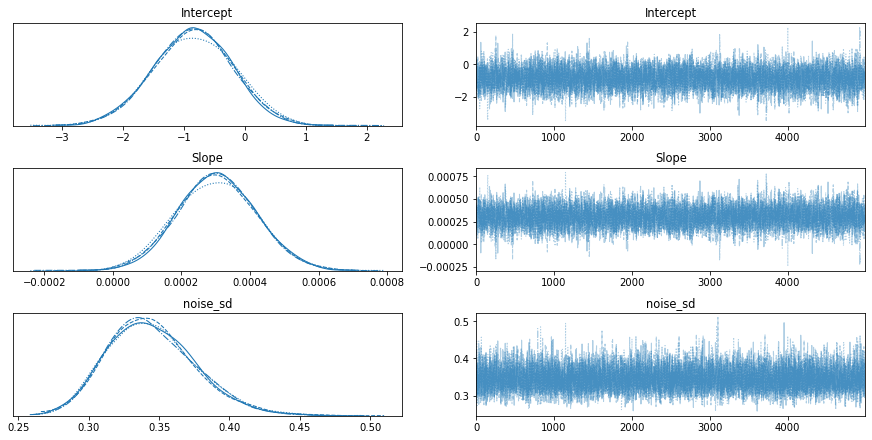

In [16]:
pm.traceplot(trace);

Now let's explore other ways to visualize our results.  First a handy function for making plots of 1-D distributions like in the book.

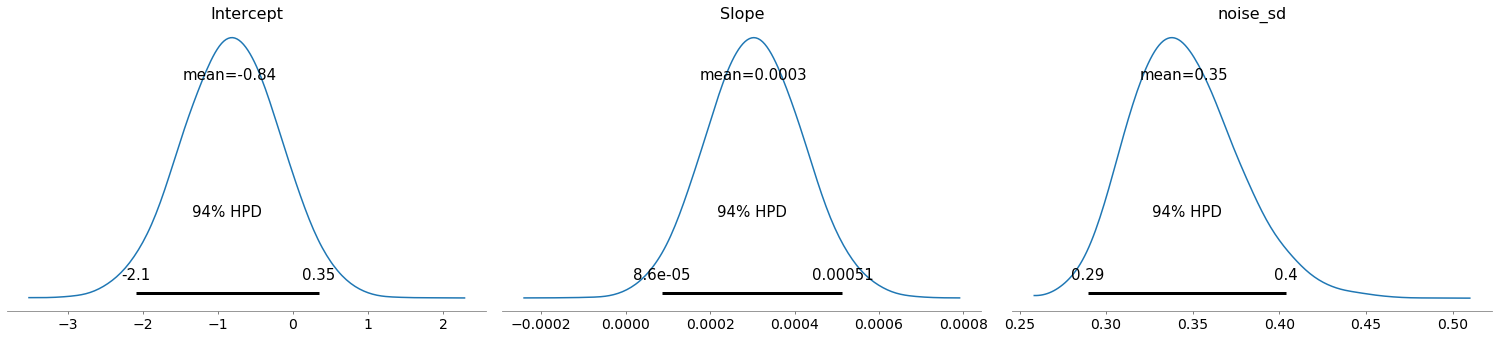

In [17]:
pm.plot_posterior(trace);

What about correlations between parameters?

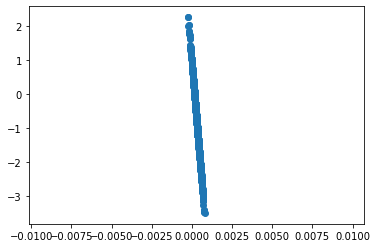

In [18]:
plt.scatter(trace['Slope'], trace['Intercept']);

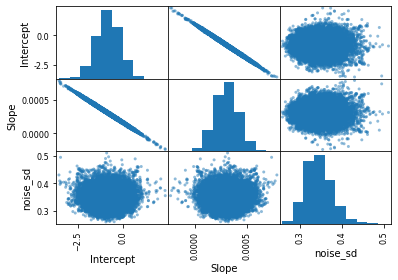

In [19]:
pd.plotting.scatter_matrix(pm.trace_to_dataframe(trace));

How well are we fitting the data?  First let's just look at the model corresponding to the last sample of our chains.

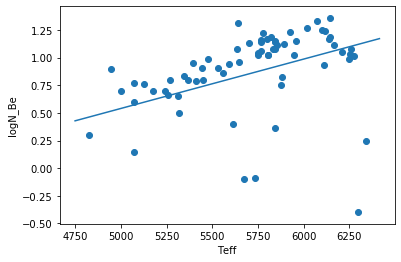

In [20]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)

last_sample = trace[-1]
plt.plot(xs, xs * last_sample['Slope'] + last_sample['Intercept']);

To get a better understanding of the uncertainty in our model constaints, let's look at models corresponding to several posterior samples at random.

In [21]:
Ndraws = 10
# The length of a multitrace is the length of the individual chains 
# To get the total number of sample we can look at a single parameter (chains are implicitly concatenated)
Nsamples = len(trace['Slope'])  
draw = np.random.choice(Nsamples, size=Ndraws)

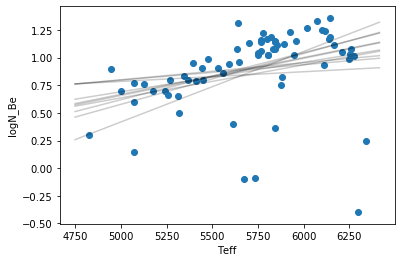

In [22]:
plt.scatter(df.Teff, df.logN_Be)
plt.xlabel(df.Teff.name)
plt.ylabel(df.logN_Be.name)

for idx in draw:
    plt.plot(xs, trace['Intercept'][idx] + xs * trace['Slope'][idx], color='k', alpha=0.2)